# Dispersion Plots

In [1]:
import os
import sys 
import json
import codecs
import requests

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

In [2]:
# yellowbrick.text.dispersion
# Implementations of lexical dispersions for text visualization.
#
# Author:   Larry Gray
# Created:  2018-06-21 10:06
#
# Copyright (C) 2018 District Data Labs
# For license information, see LICENSE.txt
#
# ID: dispersion.py [] lwgray@gmail.com $

"""
Implementation of lexical dispersion for text visualization
"""


##########################################################################
## Imports
##########################################################################

from collections import defaultdict
import itertools

from yellowbrick.text.base import TextVisualizer
from yellowbrick.style.colors import resolve_colors
from yellowbrick.exceptions import YellowbrickValueError

import numpy as np

##########################################################################
## Dispersion Plot Visualizer
##########################################################################

class DispersionPlot(TextVisualizer):
    """
    DispersionPlotVisualizer allows for visualization of the lexical dispersion
    of words in a corpus.  Lexical dispersion is a measure of a word's
    homeogeneity across the parts of a corpus.  This plot notes the occurences
    of a word and how many words from the beginning it appears.

    Parameters
    ----------
    target_words : list
        A list of target words whose dispersion across a corpus passed at fit
	will be visualized.

    ax : matplotlib axes, default: None
        The axes to plot the figure on.

    labels : list of strings
        The names of the classes in the target, used to create a legend.
        Labels must match names of classes in sorted order.

    colors : list or tuple of colors
        Specify the colors for each individual class

    colormap : string or matplotlib cmap
        Qualitative colormap for discrete target

    ignore_case : boolean, default: False
	Specify whether input  will be case-sensitive.

    annotate_docs : boolean, default: False
        Specify whether document boundaries will be displayed.  Vertical lines
        are positioned at the end of each document.

    kwargs : dict
        Pass any additional keyword arguments to the super class.

    These parameters can be influenced later on in the visualization
    process, but can and should be set as early as possible.
    """

    # NOTE: cannot be np.nan
    NULL_CLASS = None

    def __init__(self, target_words, ax=None, colors=None, ignore_case=False,
                 annotate_docs=False, labels=None, colormap=None, **kwargs):
        super(DispersionPlot, self).__init__(ax=ax, **kwargs)

        self.labels = labels
        self.colors = colors
        self.colormap = colormap

        self.target_words = target_words
        self.ignore_case = ignore_case
        self.annotate_docs = annotate_docs

    def _compute_dispersion(self, text, y):
        self.boundaries_ = []
        offset = 0


        if y is None:
            y = itertools.repeat(None)

        for doc, target in zip(text, y):
            for word in doc:
                if self.ignore_case:
                    word = word.lower()

                # NOTE: this will find all indices if duplicate words are supplied
                # In the case that word is not in target words, any empty list is
                # returned and no data will be yielded
                offset += 1
                for y_coord in (self.indexed_words_ == word).nonzero()[0]:
                    y_coord = int(y_coord)
                    yield (offset, y_coord, target)
            if self.annotate_docs:
                self.boundaries_.append(offset)
        self.boundaries_ = np.array(self.boundaries_, dtype=int)

    def _check_missing_words(self, points):
        for index in range(len(self.indexed_words_)):
            if index in points[:,1]:
                pass
            else:
                raise YellowbrickValueError((
                    "The indexed word '{}' is not found in "
                    "this corpus"
                    ).format(self.indexed_words_[index]))

    def fit(self, X, y=None, **kwargs):
        """
        The fit method is the primary drawing input for the dispersion
        visualization.

        Parameters
        ----------
        X : list or generator
            Should be provided as a list of documents or a generator
            that yields a list of documents that contain a list of 
            words in the order they appear in the document.

        y : ndarray or Series of length n
            An optional array or series of target or class values for
            instances. If this is specified, then the points will be colored
            according to their class.

        kwargs : dict
            Pass generic arguments to the drawing method

        Returns
        -------
        self : instance
            Returns the instance of the transformer/visualizer
        """

        if y is not None:
            self.classes_ = np.unique(y)
        elif y is None and self.labels is not None:
            self.classes_ = np.array([self.labels[0]])
        else:
            self.classes_ = np.array([self.NULL_CLASS])

        # Create an index (e.g. the y position) for the target words
        self.indexed_words_ = np.flip(self.target_words, axis=0)
        if self.ignore_case:
            self.indexed_words_ = np.array([w.lower() for w in self.indexed_words_])

        # Stack is used to create a 2D array from the generator
        try:
            points_target = np.stack(self._compute_dispersion(X, y))
        except ValueError:
            raise YellowbrickValueError((
                "No indexed words were found in the corpus"
                ))
        points = np.stack(zip(points_target[:,0].astype(int),
                              points_target[:,1].astype(int)))

        self.target = points_target[:,2]

        self._check_missing_words(points)

        self.draw(points, self.target)
        return self

    def draw(self, points, target=None, **kwargs):
        """
        Called from the fit method, this method creates the canvas and
        draws the plot on it.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """

        # Resolve the labels with the classes
        labels = self.labels if self.labels is not None else self.classes_
        if len(labels) != len(self.classes_):
            raise YellowbrickValueError((
                "number of supplied labels ({}) does not "
                "match the number of classes ({})"
            ).format(len(labels), len(self.classes_)))

        # Create the color mapping for the labels.
        color_values = resolve_colors(
            n_colors=len(labels), colormap=self.colormap, colors=self.color)
        colors = dict(zip(labels, color_values))

        # Transform labels into a map of class to label
        labels = dict(zip(self.classes_, labels))

        # Define boundaries with a vertical line
        if self.annotate_docs:
            for xcoords in self.boundaries_:
                self.ax.axvline(x=xcoords, color='lightgray', linestyle='dashed')

        series = defaultdict(lambda: {'x':[], 'y':[]})

        if target is not None:
            for point, t in zip(points, target):
                label = labels[t]
                series[label]['x'].append(point[0])
                series[label]['y'].append(point[1])
        else:
            label = self.classes_[0]
            for x, y in points:
                series[label]['x'].append(x)
                series[label]['y'].append(y)

        for label, points in series.items():
            self.ax.scatter(points['x'], points['y'], marker='|',
                            c=colors[label], zorder=100, label=label)

        self.ax.set_yticks(list(range(len(self.indexed_words_))))
        self.ax.set_yticklabels(self.indexed_words_)

    def finalize(self, **kwargs):
        """
        The finalize method executes any subclass-specific axes
        finalization steps. The user calls show & show calls finalize.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """

        self.ax.set_ylim(-1, len(self.indexed_words_))
        self.ax.set_title("Lexical Dispersion Plot")
        self.ax.set_xlabel("Word Offset")
        self.ax.grid(False)

        # Add the legend outside of the figure box.
        if not all(self.classes_ == np.array([self.NULL_CLASS])):
            box = self.ax.get_position()
            self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            self.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##########################################################################
## Quick Method
##########################################################################

def dispersion(words, corpus, y=None, ax=None, colors=None, colormap=None,
               labels=None, annotate_docs=False, ignore_case=False, **kwargs):
    """ Displays lexical dispersion plot for words in a corpus

    This helper function is a quick wrapper to utilize the DisperstionPlot
    Visualizer for one-off analysis

    Parameters
    ----------

    words : list
        A list of words whose dispersion will be examined within a corpus

    y : ndarray or Series of length n
        An optional array or series of target or class values for
        instances. If this is specified, then the points will be colored
        according to their class.

    corpus : list
        Should be provided as a list of documents that contain
        a list of words in the order they appear in the document.

    ax : matplotlib axes, default: None
        The axes to plot the figure on.

    labels : list of strings
        The names of the classes in the target, used to create a legend.
        Labels must match names of classes in sorted order.

    colors : list or tuple of colors
        Specify the colors for each individual class

    colormap : string or matplotlib cmap
        Qualitative colormap for discrete target

    annotate_docs : boolean, default: False
        Specify whether document boundaries will be displayed.  Vertical lines
        are positioned at the end of each document.

    ignore_case : boolean, default: False
	Specify whether input  will be case-sensitive.

    kwargs : dict
        Pass any additional keyword arguments to the super class.

    Returns
    -------
    ax: matplotlib axes
        Returns the axes that the plot was drawn on
    """

    # Instantiate the visualizer
    visualizer = DispersionPlot(
        words, ax=ax, colors=colors, colormap=colormap,
        ignore_case=ignore_case, labels=labels,
        annotate_docs=annotate_docs, **kwargs
    )

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(corpus, y, **kwargs)

    # Return the axes object on the visualizer
    return visualizer.ax


In [3]:
URL = "https://raw.githubusercontent.com/foxbook/atap/master/snippets/ch08/data/oz.json"

def fetch_data(fname='oz.json'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
oz_json = fetch_data()

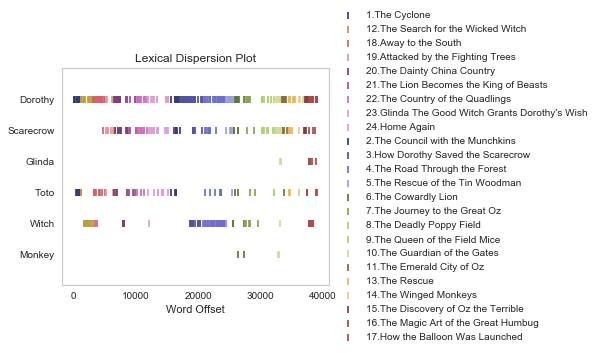

In [4]:
# oz.json contains a list of characters, reverse sorted by frequency
# And a dict with {chapter title: chapter text} key-value pairs
with codecs.open('oz.json', 'r', 'utf-8-sig') as data:
    text = json.load(data)
    chapters = text['chapters']
    titles = list(chapters.keys())
    
    target_characters = ["Dorothy", "Scarecrow", "Glinda", "Toto", "Witch", "Monkey"]
    chapter_text = [chap.split() for chap in chapters.values()]
    
    oz = DispersionPlot(target_characters, colormap='tab20b', labels=titles)
    oz.fit(chapter_text, titles)
    oz.show()